In [1]:
import multiprocessing
import pandas as pd
import altair as alt
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn import utils
from wordcloud import WordCloud
from gensim import models
from models_helper_functions import prepare_target_articles
from articles_preprocessing_for_word2vec import load_stop_words

### Load articles
Using prepare_target_articles function we can choose to create a dataframe of articles intended for political bias classification

In [2]:
classification_type = 'political_bias'

merged_df, labels_dict = prepare_target_articles(classification_type=classification_type, 
                                                 keep_english=False, 
                                                 balance_classes=False)

In [3]:
merged_df.head(5)

,main_text,source_label,title,subtitle,tags,upload_time,political_bias_label,processed_main_text
0,&laquo;Σαράντα έξι χρόνια από την αποκατάσταση...,0,Φ. Γεννηματά: Η σημερινή μέρα στιγματίζεται απ...,&laquo;Σαράντα έξι χρόνια από την αποκατάσταση...,"['ΑΓΙΑ ΣΟΦΙΑ, ΚΙΝΑΛ, ΠΟΛΙΤΙΚΗ']",2020-07-24 18:41:31+00:00,1.0,σαράντα έξι χρόνια από την αποκατάσταση...
1,&laquo;Καμία μετατροπή της Αγιάς Σοφιάς σε τέμ...,0,Αλ. Τσίπρας: Καμία μετατροπή της Αγίας Σοφίας ...,&laquo;Καμία μετατροπή της Αγιάς Σοφιάς σε τέμ...,"['ΑΓΙΑ ΣΟΦΙΑ, ΤΣΙΠΡΑΣ ΑΛΕΞΗΣ, ΠΟΛΙΤΙΚΗ']",2020-07-24 18:13:45+00:00,1.0,καμία μετατροπή της αγιάς σοφιάς σε τέμ...
2,Η Αγία Σοφία είναι ένα οικουμενικό μνημείο με ...,0,Ν. Αναστασιάδης: Ευθεία προσβολή στην παγκόσμι...,Η Αγία Σοφία είναι ένα οικουμενικό μνημείο με ...,"['ΑΓΙΑ ΣΟΦΙΑ, ΝΙΚΟΣ ΑΝΑΣΤΑΣΙΑΔΗΣ, ΠΟΛΙΤΙΚΗ']",2020-07-24 17:55:15+00:00,1.0,η αγία σοφία είναι ένα οικουμενικό μνημείο με ...
3,Ο Ταγίπ Ερντογάν τιμωρεί την Κωνσταντινούπολη ...,0,"Αποψη: Στόχος, η συσπείρωση ψηφοφόρων",Η ομάδα που&nbsp;επιδοκίμασε τη λειτουργία του...,"['ΑΓΙΑ ΣΟΦΙΑ, ΕΡΝΤΟΓΑΝ, ΤΟΥΡΚΙΑ, ΠΟΛΙΤΙΚΗ']",2020-07-24 17:16:33+00:00,1.0,ο ταγίπ ερντογάν τιμωρεί την κωνσταντινούπολη ...
4,Την άμεση απομάκρυνση του Κωνσταντίνου Καλέμη ...,0,Υπ. Παιδείας: Απομάκρυνση συντονιστή εκπαίδευσ...,Την άμεση απομάκρυνση του Κωνσταντίνου Καλέμη ...,"['ΕΚΠΑΙΔΕΥΣΗ, ΠΟΛΙΤΙΚΗ']",2020-07-24 16:39:37+00:00,1.0,την άμεση απομάκρυνση του κωνσταντίνου καλέμη ...


### Create dov2vec representation for the acticles

In [4]:
# load stop words
stop_words = load_stop_words()

# create TaggedDocument representations for train and test articles (list of article tokens along with label)
tagged_docs = []
for article, label in zip(merged_df['processed_main_text'], merged_df['political_bias_label']):
    tagged_docs.append(models.doc2vec.TaggedDocument(words=[w for w in article.split() if w not in stop_words and len(w)>=2], tags=[label]))

# define number of cpu to be used for training
cores = multiprocessing.cpu_count()

# dm = 0 -> distributed bag of words
model_dbow = models.Doc2Vec(dm=0, 
                            vector_size=100, 
                            negative=5, 
                            hs=0, 
                            min_count=10, 
                            workers=cores)

# build vocabulary based on train documents
model_dbow.build_vocab(tagged_docs)

# train model
model_dbow.train(utils.shuffle(tagged_docs), total_examples=len(tagged_docs), epochs=10)

# final representations
X, y = zip(*[(model_dbow.infer_vector(article.words, steps=20), article.tags[0]) for article in tagged_docs])

### Kmeans clustering
After lots of experimentation with kmeans and agglomerative clustering techniques we chose Kmeans with 3 clusters.

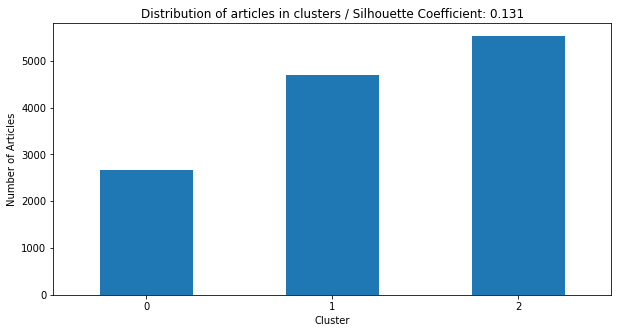

In [5]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)

# calculate silhouette score
silhouette_coefficient = metrics.silhouette_score(X, kmeans.labels_)

# add cluster label to each article
merged_df['cluster'] = kmeans.labels_

# plot the distribution of articles in clusters
merged_df['cluster'].value_counts().plot.bar(rot=0,
                                                figsize=(10,5),
                                                xlabel='Cluster',
                                                ylabel='Number of Articles', 
                                                title='Distribution of articles in clusters / Silhouette Coefficient: {:.3f}'.\
                                                         format(silhouette_coefficient));

### Reduce dimensionality of article representation into 2d
We use PCA to reduce the dimension of the article representations in order to visualize them in a 2d graph

In [6]:
# define and fit pca model
pca = PCA(n_components=2)
pca.fit(X)

# transform data and add them to a pandas dataframe
transformed_data = pca.transform(X)
# create a df of the transformed data points
transformed_data = pd.DataFrame(transformed_data, columns=['x', 'y'])

# merge them along with the articles
merged_df = pd.concat([merged_df.reset_index(drop=True), transformed_data], axis=1)

In [7]:
# create political_polarity column for visualization purposes
merged_df['political_polarity'] = merged_df['political_bias_label'].replace(dict((v, k) for k, v in labels_dict.items()))

# create a column named source_name that has the actual name of sources for visualization purposes
source_labels_dict = {0: 'kathimerini', 1:'kontra', 4: 'efsyn', 6:'skai'}
merged_df['source_name'] = merged_df['source_label'].replace(source_labels_dict)

In [8]:
merged_df.head(5)

,main_text,source_label,title,subtitle,tags,upload_time,political_bias_label,processed_main_text,cluster,x,y,political_polarity,source_name
0,&laquo;Σαράντα έξι χρόνια από την αποκατάσταση...,0,Φ. Γεννηματά: Η σημερινή μέρα στιγματίζεται απ...,&laquo;Σαράντα έξι χρόνια από την αποκατάσταση...,"['ΑΓΙΑ ΣΟΦΙΑ, ΚΙΝΑΛ, ΠΟΛΙΤΙΚΗ']",2020-07-24 18:41:31+00:00,1.0,σαράντα έξι χρόνια από την αποκατάσταση...,2,-0.117302,-0.210954,right,kathimerini
1,&laquo;Καμία μετατροπή της Αγιάς Σοφιάς σε τέμ...,0,Αλ. Τσίπρας: Καμία μετατροπή της Αγίας Σοφίας ...,&laquo;Καμία μετατροπή της Αγιάς Σοφιάς σε τέμ...,"['ΑΓΙΑ ΣΟΦΙΑ, ΤΣΙΠΡΑΣ ΑΛΕΞΗΣ, ΠΟΛΙΤΙΚΗ']",2020-07-24 18:13:45+00:00,1.0,καμία μετατροπή της αγιάς σοφιάς σε τέμ...,1,1.893311,-0.813429,right,kathimerini
2,Η Αγία Σοφία είναι ένα οικουμενικό μνημείο με ...,0,Ν. Αναστασιάδης: Ευθεία προσβολή στην παγκόσμι...,Η Αγία Σοφία είναι ένα οικουμενικό μνημείο με ...,"['ΑΓΙΑ ΣΟΦΙΑ, ΝΙΚΟΣ ΑΝΑΣΤΑΣΙΑΔΗΣ, ΠΟΛΙΤΙΚΗ']",2020-07-24 17:55:15+00:00,1.0,η αγία σοφία είναι ένα οικουμενικό μνημείο με ...,1,1.765399,-0.014699,right,kathimerini
3,Ο Ταγίπ Ερντογάν τιμωρεί την Κωνσταντινούπολη ...,0,"Αποψη: Στόχος, η συσπείρωση ψηφοφόρων",Η ομάδα που&nbsp;επιδοκίμασε τη λειτουργία του...,"['ΑΓΙΑ ΣΟΦΙΑ, ΕΡΝΤΟΓΑΝ, ΤΟΥΡΚΙΑ, ΠΟΛΙΤΙΚΗ']",2020-07-24 17:16:33+00:00,1.0,ο ταγίπ ερντογάν τιμωρεί την κωνσταντινούπολη ...,1,0.653774,0.434995,right,kathimerini
4,Την άμεση απομάκρυνση του Κωνσταντίνου Καλέμη ...,0,Υπ. Παιδείας: Απομάκρυνση συντονιστή εκπαίδευσ...,Την άμεση απομάκρυνση του Κωνσταντίνου Καλέμη ...,"['ΕΚΠΑΙΔΕΥΣΗ, ΠΟΛΙΤΙΚΗ']",2020-07-24 16:39:37+00:00,1.0,την άμεση απομάκρυνση του κωνσταντίνου καλέμη ...,0,-0.636607,0.384118,right,kathimerini


### Visualize clusters
We take a random sample of 5k articles and we visualize them in the 2d space.
When this graph is created you can hover over samples to see their tooltip info or select some of them with your mouse to generate the aggregations.

#### Attention
When this interactive graph is generated data is embedded in the code of the jupyter notebook making it 180mb! For this reason we have uncommented the last line of next block if you want to use this interactive graph uncomment that line to create it.

#### Sample Image
<img src="./interactive_visualization.png" width="1200" />

In [ ]:
# define selection area properties
brush = alt.selection(type='interval', resolve='global')

base = alt.Chart(merged_df.sample(n=5000, random_state=1)).mark_circle().encode(
    y='y',
    tooltip=['title',
             'source_name',
             'political_polarity',
             'tags',
             'upload_time']
).add_selection(
    brush
).properties(
    width=1000,
    height=600
)


clusters = base.encode(x='x', 
                        color=alt.condition(brush,
                        'cluster:N',
                        alt.ColorValue('gray')))

articles_distribution_source = alt.Chart(merged_df.sample(n=5000, random_state=1)).mark_bar().encode(
    x=alt.X('count(main_text)', axis=alt.Axis(title='Number of documents', format=(".2s"))),
    y=alt.Y('source_name:N', axis=alt.Axis(title='Media source')),
    color=alt.Color('source_name:N')
).transform_filter(brush).properties(width=1000)

articles_distribution_polarity = alt.Chart(merged_df.sample(n=5000, random_state=1)).mark_bar().encode(
    x=alt.X('count(main_text)', axis=alt.Axis(title='Number of documents', format=(".2s"))),
    y=alt.Y('political_polarity:N', axis=alt.Axis(title='Political polarity')),
    color=alt.Color('political_polarity:N')
).transform_filter(brush).properties(width=1000)


graph = clusters & articles_distribution_source & articles_distribution_polarity

# this line will save the interactive graph as an html page with embedded data 
# attantion its size is about 180mb
graph.save('clustering.html')

# this line will plot the interactive graph here making this notebook 180mb 
# to create it uncomment next line line
#graph

### Word cloud of clusters

Cluster: 2


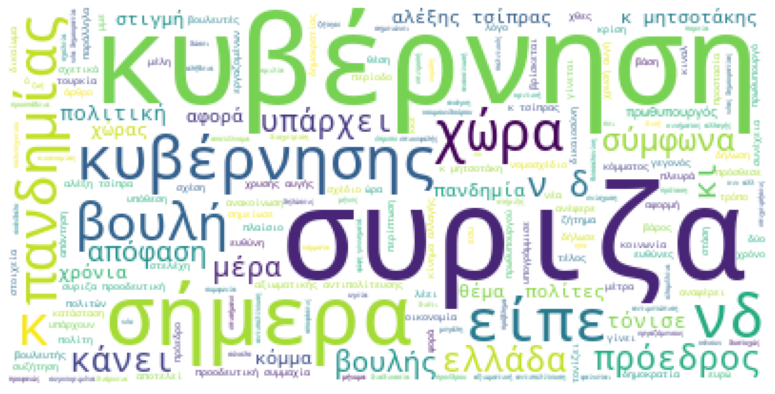

Cluster: 1


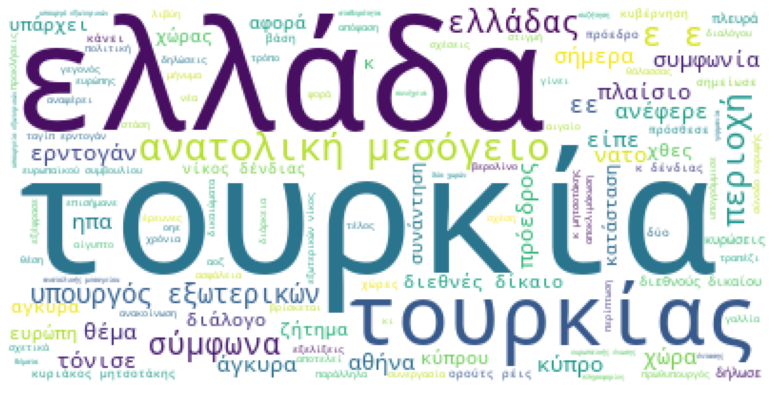

Cluster: 0


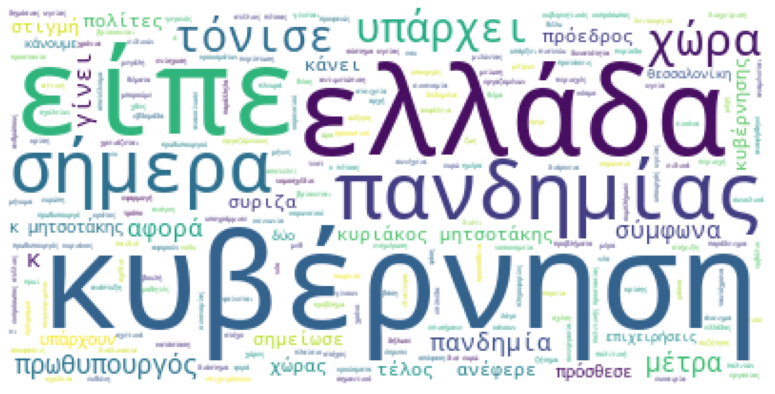

In [10]:
for cluster in merged_df['cluster'].unique().tolist():
    print('Cluster: {}'.format(cluster))
    combined_text = ' '.join(article for article in merged_df[merged_df['cluster'] == cluster]['processed_main_text'])
    
    
    wordcloud = WordCloud(stopwords=stop_words, background_color="white").generate(combined_text)
    
    plt.figure(figsize=(16,7))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

### Word clouds of political polarity

Political polarity: left


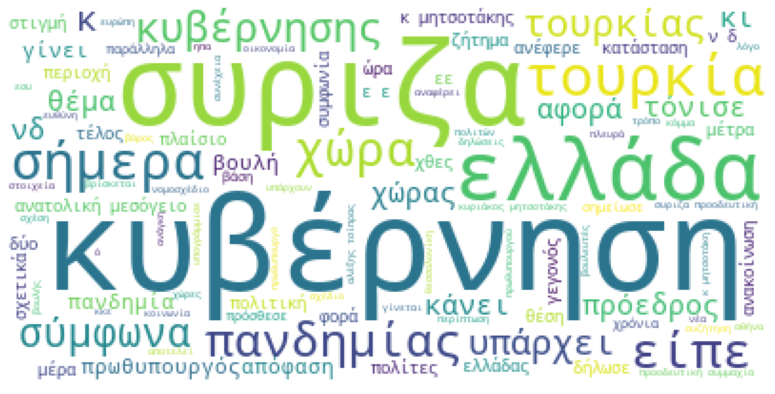

Political polarity: right


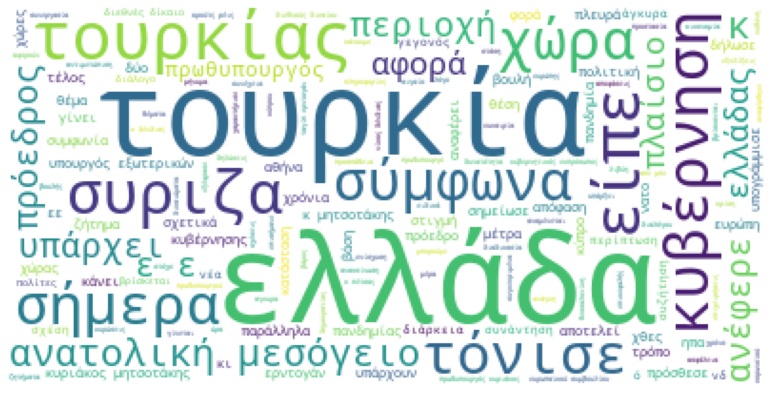

In [11]:
for polarity in ['left', 'right']:
    print('Political polarity: {}'.format(polarity))
    combined_text = ' '.join(article for article in merged_df[merged_df['political_polarity'] == polarity]['processed_main_text'])
    
    
    wordcloud = WordCloud(stopwords=stop_words, background_color="white").generate(combined_text)
    
    plt.figure(figsize=(16,7))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()